<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2023/blob/main/ML_day12/12_3_bankruptcy_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bankruptcy Prediction with PyTorch

Now, we will use Taiwanese stock exchange data to predict bankruptcy. This challenge was a Kaggle competition and you can check out the original data description from the link below.

Kaggle Link: https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction

I refer to some Kaggle notebooks for this part
* https://www.kaggle.com/code/xingyuchencse6250/supervised-learning-company-bankruptcy-prediction#Algorithm-2-Neural-Network
* https://www.kaggle.com/code/gcmadhan/bankruptcy-perdiction-96-accuracy

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
url = "https://raw.githubusercontent.com/spros1/TaiwaneseBankruptcyPrediction/main/Dataset/data.csv"

In [4]:
df = pd.read_csv(url)

In [5]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [6]:
df.shape

(6819, 96)

In [7]:
# no null values!
df.isnull().sum().sum()

0

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [9]:
df['Bankrupt?'].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

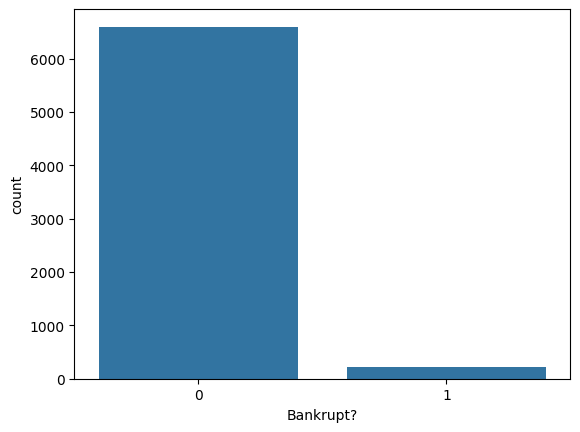

In [10]:
sns.countplot(x=df['Bankrupt?'])
plt.show()

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:
X=df.drop(labels=['Bankrupt?'], axis=1)
y=df['Bankrupt?']

In [13]:
oversample = SMOTE()
X,y=oversample.fit_resample(X,y)

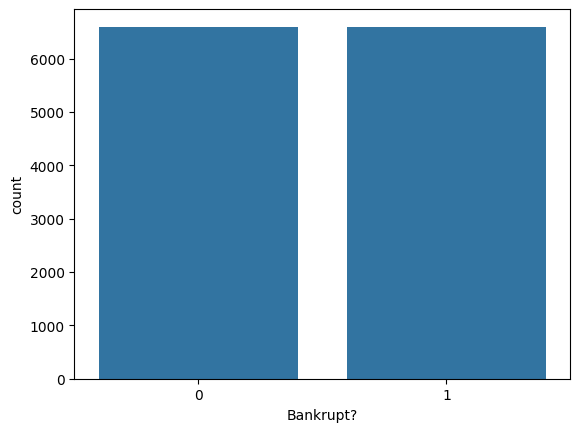

In [20]:
sns.countplot(x=y)
plt.show()

In [14]:
# scaling
from sklearn.preprocessing import MinMaxScaler
# data split
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test,y_train,y_test = train_test_split(X, y,stratify=y)

In [16]:
std = MinMaxScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [17]:
X_train.shape, X_test.shape

((9898, 95), (3300, 95))

In [18]:
from torch.utils.data import DataLoader, TensorDataset

In [19]:
batch_size = 4

In [20]:
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train.values).view(-1,1))

In [21]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [22]:
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test.values).view(-1,1))

In [23]:
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=False)

In [25]:
# class Network(nn.Module):
#   def __init__(self, n_input, n_hidden, n_output):
#     super(Network, self).__init__()
#     self.hidden1 = nn.Linear(n_input, n_hidden)
#     self.hidden2 = nn.Linear(n_hidden, n_hidden)
#     self.out = nn.Linear(n_hidden, n_output)

#   def forward(self, x):
#       x = F.relu(self.hidden1(x))
#       x = F.relu(self.hidden2(x))
#       x = torch.sigmoid(self.out(x))
#       return x

In [84]:
class LSTMNetwork(nn.Module):
    def __init__(self, n_input, n_hidden, n_output, num_layers=1):
        super(LSTMNetwork, self).__init__()
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        self.lstm = nn.LSTM(n_input, n_hidden, num_layers, batch_first=True)
        self.out = nn.Linear(n_hidden, n_output)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.n_hidden).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.n_hidden).to(x.device)

        x = x.view(x.size(0), 1, -1) #4, 1, 95
        out, _ = self.lstm(x, (h0, c0))

        out = self.out(out[:, -1, :])
        out = torch.sigmoid(out)
        return out

In [85]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = LSTMNetwork(n_input = 95, n_hidden = 5, n_output = 1, num_layers=2).to(device)

In [86]:
print(model)

LSTMNetwork(
  (lstm): LSTM(95, 5, num_layers=2, batch_first=True)
  (out): Linear(in_features=5, out_features=1, bias=True)
)


In [87]:
loss = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [98]:
num_epochs = 10

In [102]:
for epoch in range(num_epochs):
    # set the model as train mode
    model.train()

    for i, (batch_data, batch_labels) in enumerate(train_loader):
      X = batch_data.to(device)
      Y = batch_labels.to(device)

      pre = model(X)
      cost = loss(pre, Y.float())

      optimizer.zero_grad()
      cost.backward()
      optimizer.step()

      if i % 1000 == 0:
        print(f"Iteration {i}, Epoch {epoch}, Loss: {cost.item()}")

Iteration 0, Epoch 0, Loss: 0.7346749305725098
Iteration 1000, Epoch 0, Loss: 0.12993556261062622
Iteration 2000, Epoch 0, Loss: 0.6816422343254089
Iteration 0, Epoch 1, Loss: 0.18280786275863647
Iteration 1000, Epoch 1, Loss: 0.10802198946475983
Iteration 2000, Epoch 1, Loss: 0.06564125418663025
Iteration 0, Epoch 2, Loss: 0.5377211570739746
Iteration 1000, Epoch 2, Loss: 0.09421064704656601
Iteration 2000, Epoch 2, Loss: 0.10794629156589508
Iteration 0, Epoch 3, Loss: 0.11503966897726059
Iteration 1000, Epoch 3, Loss: 0.2599632740020752
Iteration 2000, Epoch 3, Loss: 0.11526086181402206
Iteration 0, Epoch 4, Loss: 0.11934949457645416
Iteration 1000, Epoch 4, Loss: 0.2648974657058716
Iteration 2000, Epoch 4, Loss: 0.2524055540561676
Iteration 0, Epoch 5, Loss: 0.10362593084573746
Iteration 1000, Epoch 5, Loss: 0.716008186340332
Iteration 2000, Epoch 5, Loss: 0.08001760393381119
Iteration 0, Epoch 6, Loss: 0.7985409498214722
Iteration 1000, Epoch 6, Loss: 0.07397212088108063
Iteration 

In [103]:
model.eval()

correct = 0
total = 0

for i, (data, labels) in enumerate(test_loader):
    data = data.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(data)

    predicted = outputs.squeeze().data > 0.5
    labels = labels.squeeze().bool()

    total += data.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy: %f %%' % (100 * float(correct) / total))

Accuracy: 89.030303 %
